## Overview:

Use pipeline to get an overall idea of observed stars and observed galaxies per pixel. Do this on large scales (maybe several 32 res healpixels?), but do it for many locations to get many different distributions of counts. Then weight observed balrog stars (not necessarily classified balrog stars) in the isochrone with the same weight across the board so that their average count per 512 pixel is the same as in the gold data (or at least a region of the gold data). After this, do the same for observed balrog galaxies. With this weighting, get classified star and galaxy counts. Try to then recover the survey independent counts using probability maps. Check before and after $N/\langle N\rangle$ for both stars and galaxies. Since balrog injections were random, in theory these numbers should start out with strong deviations from 1 but they should hopefully both drop to unity. Also make sure to weight according to magnitude.

In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import healpy as hp
import healsparse as hsp
import skyproj
from numpy import loadtxt
import StellarConfig as strConfig
import Config

In [2]:
obsStarPerPixel = np.array([11.034763594729077, 5.46824947222127, 5.327817349228764, 15.256181624036115, 30.886590162746476])
obsGalaPerPixel = np.array([4.415052356191168, 28.718253595263395, 38.06604768144608, 53.82725395878597, 48.4083791624069])

## Pseudo-Code Algorithm

Use det star and galaxy files from the stellar stream pipeline. First check how good the overlap is on pixels. This shouldn't really matter at the end of the day, but it would still be good to know. Get an overall group of pixels (probably the union of star pixels and galaxy pixels, maybe something else down the line). For each pixel, figure out classified star and galaxy counts. Weight observed star and galaxy counts so that the observed number of objects in each magnitude bin has a count per pixel that matches the above numbers. After this, add these objects to the classified pixels depending on their classification. Add them with their weight. This is our "classified" sample. After this, just run the correction pipeline I was running before. The recovered corrected maps, for both stars and galaxies, should be completely random and have less relation on the survey properties as compared to their original counts.

In [3]:
res = strConfig.res
numBins = strConfig.numBins
sigma = strConfig.sigma

detStarAllPosFile = strConfig.detStarAllPosFile
detGalaAllPosFile = strConfig.detGalaAllPosFile

galaExtrFiles = strConfig.galaExtrFiles
galaTrainFiles = strConfig.galaTrainFiles
galaProbFiles = strConfig.galaProbFiles

galaDetExtrFiles = strConfig.galaDetMeasDataExtrFiles
galaDetTrainFiles = strConfig.galaDetMeasDataTrainFiles
galaDetProbFiles = strConfig.galaDetMeasDataProbFiles

galaDetAsGalaExtrFiles = strConfig.galaDetMeasDataAsGalaExtrFiles
galaDetAsGalaTrainFiles = strConfig.galaDetMeasDataAsGalaTrainFiles
galaDetAsGalaProbFiles = strConfig.galaDetMeasDataAsGalaProbFiles

starExtrFiles = strConfig.starExtrFiles
starTrainFiles = strConfig.starTrainFiles
starProbFiles = strConfig.starProbFiles

starDetExtrFiles = strConfig.starDetMeasDataExtrFiles
starDetTrainFiles = strConfig.starDetMeasDataTrainFiles
starDetProbFiles = strConfig.starDetMeasDataProbFiles

starDetAsGalaExtrFiles = strConfig.starDetMeasDataAsGalaExtrFiles
starDetAsGalaTrainFiles = strConfig.starDetMeasDataAsGalaTrainFiles
starDetAsGalaProbFiles = strConfig.starDetMeasDataAsGalaProbFiles

calibrationFile = strConfig.calibrationFile

pixFile = strConfig.pixFile
validPix = fitsio.read(pixFile)['PIXEL']

In [4]:
allStarPix = hp.ang2pix(res, fitsio.read(detStarAllPosFile)['RA'], fitsio.read(detStarAllPosFile)['DEC'], nest = True, lonlat = True)
allGalaPix = hp.ang2pix(res, fitsio.read(detGalaAllPosFile)['RA'], fitsio.read(detGalaAllPosFile)['DEC'], nest = True, lonlat = True)
allBalrPix = np.union1d(allStarPix, allGalaPix)
allBalrPix = allBalrPix[np.isin(allBalrPix, validPix)]

In [5]:
detStarFile = strConfig.detStarMeasDataFile
detGalaFile = strConfig.detGalaMeasDataFile

In [6]:
detStarData = fitsio.read(detStarFile)
detStarPix = hp.ang2pix(res, detStarData['RA'], detStarData['DEC'], nest = True, lonlat = True)
detStarRmag = detStarData['RMAG']
detStarClass = detStarData['CLASS']
# Slight mismatch can occur due to using measured ra and dec values.
starPixCut = np.isin(detStarPix, allBalrPix)
detStarPix = detStarPix[starPixCut]
detStarRmag = detStarRmag[starPixCut]
detStarClass = detStarClass[starPixCut]

detGalaData = fitsio.read(detGalaFile)
detGalaPix = hp.ang2pix(res, detGalaData['RA'], detGalaData['DEC'], nest = True, lonlat = True)
detGalaRmag = detGalaData['RMAG']
detGalaClass = detGalaData['CLASS']
# Slight mismatch can occur due to using measured ra and dec values.
galaPixCut = np.isin(detGalaPix, allBalrPix)
detGalaPix = detGalaPix[galaPixCut]
detGalaRmag = detGalaRmag[galaPixCut]
detGalaClass = detGalaClass[galaPixCut]

In [7]:
magBins = [22, 23, 23.5, 24, 24.5]

In [8]:
starWeights = []
for i in np.arange(len(magBins)):
    if i == 0:
        magCut = np.where(detStarRmag <= magBins[i])[0]
    else:
        magCut = np.where((detStarRmag <= magBins[i]) & (detStarRmag > magBins[i - 1]))[0]
    starWeights.append(obsStarPerPixel[i] / (len(magCut) / len(allBalrPix)))

galaWeights = []
for i in np.arange(len(magBins)):
    if i == 0:
        magCut = np.where(detGalaRmag <= magBins[i])[0]
    else:
        magCut = np.where((detGalaRmag <= magBins[i]) & (detGalaRmag > magBins[i - 1]))[0]
    galaWeights.append(obsGalaPerPixel[i] / (len(magCut) / len(allBalrPix)))

In [9]:
claStar = []
    
for i in np.arange(len(magBins)):
    if i == 0:
        magCut = np.where(detStarRmag <= magBins[i])[0]
    else:
        magCut = np.where((detStarRmag <= magBins[i]) & (detStarRmag > magBins[i - 1]))[0]
    magCutStarPix = detStarPix[magCut]
    extraPix = np.append(magCutStarPix, allBalrPix)
    claStar.append(starWeights[i] * (np.unique(extraPix, return_counts = True)[1] - 1))
    
claStar = np.array(claStar, dtype = object)

claGala = []

for i in np.arange(len(magBins)):
    if i == 0:
        magCut = np.where(detGalaRmag <= magBins[i])[0]
    else:
        magCut = np.where((detGalaRmag <= magBins[i]) & (detGalaRmag > magBins[i - 1]))[0]
    magCutGalaPix = detGalaPix[magCut]
    extraPix = np.append(magCutGalaPix, allBalrPix)
    claGala.append(galaWeights[i] * (np.unique(extraPix, return_counts = True)[1] - 1))
    
claGala = np.array(claGala, dtype = object)

In [10]:
caliData = fitsio.read(calibrationFile)
starAdjustments = caliData['STAR']
galaAdjustments = caliData['GALA']

In [11]:
aveStarDet = []
for starDetTrainFile in starDetTrainFiles:
    aveStarDet.append(loadtxt(starDetTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    
aveStarDetAsGala = []
for starDetAsGalaTrainFile in starDetAsGalaTrainFiles:
    aveStarDetAsGala.append(loadtxt(starDetAsGalaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    
aveGalaDet = []
for galaDetTrainFile in galaDetTrainFiles:
    aveGalaDet.append(loadtxt(galaDetTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    
aveGalaDetAsGala = []
for galaDetAsGalaTrainFile in galaDetAsGalaTrainFiles:
    aveGalaDetAsGala.append(loadtxt(galaDetAsGalaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))

In [12]:
probCut = np.isin(validPix, allBalrPix)

starDetProb = []
for i in range(len(magBins)):
    nextProb = fitsio.read(starDetProbFiles[i])['SIGNAL']
    nextProb[np.where(nextProb < 0)[0]] = 0
    starDetProb.append(nextProb[probCut])
starDetProb = np.array(starDetProb, dtype = object)

starDetAsGalaProb = []
for i in range(len(magBins)):
    nextProb = fitsio.read(starDetAsGalaProbFiles[i])['SIGNAL']
    nextProb[np.where(nextProb < 0)[0]] = 0
    starDetAsGalaProb.append(nextProb[probCut])
starDetAsGalaProb = np.array(starDetAsGalaProb, dtype = object)

starCorrProb = []
for i in range(len(magBins)):
    starCorrProb.append(np.clip(starAdjustments[i] * fitsio.read(starProbFiles[i])['SIGNAL'], 0, 1)[probCut])
starCorrProb = np.array(starCorrProb, dtype = object)

galaDetProb = []
for i in range(len(magBins)):
    nextProb = fitsio.read(galaDetProbFiles[i])['SIGNAL']
    nextProb[np.where(nextProb < 0)[0]] = 0
    galaDetProb.append(nextProb[probCut])
galaDetProb = np.array(galaDetProb, dtype = object)

galaDetAsGalaProb = []
for i in range(len(magBins)):
    nextProb = fitsio.read(galaDetAsGalaProbFiles[i])['SIGNAL']
    nextProb[np.where(nextProb < 0)[0]] = 0
    galaDetAsGalaProb.append(nextProb[probCut])
galaDetAsGalaProb = np.array(galaDetAsGalaProb, dtype = object)

galaCorrProb = []
for i in range(len(magBins)):
    galaCorrProb.append(np.clip(galaAdjustments[i] * fitsio.read(galaProbFiles[i])['SIGNAL'], 0, 1)[probCut])
galaCorrProb = np.array(galaCorrProb, dtype = object)

In [13]:
origStar = np.full(len(allBalrPix), 0.0)
for i in np.arange(len(magBins)):
    origStar = origStar + claStar[i]
    
origGala = np.full(len(allBalrPix), 0.0)
for i in np.arange(len(magBins)):
    origGala = origGala + claGala[i]

In [14]:
corrStarBins = []
corrGalaBins = []
for i in np.arange(len(magBins)):
    
    obsStars = (((galaCorrProb[i] * claStar[i]) + ((galaCorrProb[i] - 1) * claGala[i])) / ((starCorrProb[i] + galaCorrProb[i] - 1))).astype(float)
    obsStars[np.where(obsStars < 0)] = 0
    obsStars[np.where(obsStars >= claStar[i] + claGala[i])] = claStar[i][np.where(obsStars >= claStar[i] + claGala[i])] + claGala[i][np.where(obsStars >= claStar[i] + claGala[i])]
    
    obsGalas = claStar[i] + claGala[i] - obsStars
    
    CsfOs = obsStars * starCorrProb[i]
    CsfOg = obsGalas * (1 - galaCorrProb[i])
    
    CgfOs = obsStars * (1 - starCorrProb[i])
    CgfOg = obsGalas * galaCorrProb[i]
    
    CsfOsCorr = CsfOs / (starDetProb[i].astype(float) / aveStarDet[i])
    CsfOgCorr = CsfOg / (galaDetProb[i].astype(float) / aveGalaDet[i])
    
    CgfOsCorr = CgfOs / (starDetAsGalaProb[i].astype(float) / aveStarDetAsGala[i])
    CgfOgCorr = CgfOg / (galaDetAsGalaProb[i].astype(float) / aveGalaDetAsGala[i])
    
    corrStarBins.append(CsfOsCorr + CsfOgCorr)
    corrGalaBins.append(CgfOsCorr + CgfOgCorr)

In [15]:
# This generates the fracDet data.
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

# This degrades it to 512 resolution and applies a cut to where there is at least 75% coverage.
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, res, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [16]:
corrStar = np.sum(corrStarBins, axis = 0)
corrGala = np.sum(corrGalaBins, axis = 0)

In [17]:
fullOrigStar = np.full(12*(res**2), hp.UNSEEN)
fullOrigStar[allBalrPix] = origStar
fullOrigStar[fracPix] = fullOrigStar[fracPix] / fracMap[fracPix]
fullOrigStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN

fullCorrStar = np.full(12*(res**2), hp.UNSEEN)
fullCorrStar[allBalrPix] = corrStar
fullCorrStar[fracPix] = fullCorrStar[fracPix] / fracMap[fracPix]
fullCorrStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN

fullOrigGala = np.full(12*(res**2), hp.UNSEEN)
fullOrigGala[allBalrPix] = origGala
fullOrigGala[fracPix] = fullOrigGala[fracPix] / fracMap[fracPix]
fullOrigGala[np.where(fracMap < 0.75)[0]] = hp.UNSEEN

fullCorrGala = np.full(12*(res**2), hp.UNSEEN)
fullCorrGala[allBalrPix] = corrGala
fullCorrGala[fracPix] = fullCorrGala[fracPix] / fracMap[fracPix]
fullCorrGala[np.where(fracMap < 0.75)[0]] = hp.UNSEEN

In [18]:
galaPix = np.where(fullOrigStar >= 0)[0]
origGalaCounts = fullOrigStar[galaPix]
corrGalaCounts = fullCorrStar[galaPix]

aveOrigCount = np.sum(origGalaCounts) / len(origGalaCounts)
aveCorrCount = np.sum(corrGalaCounts) / len(corrGalaCounts)

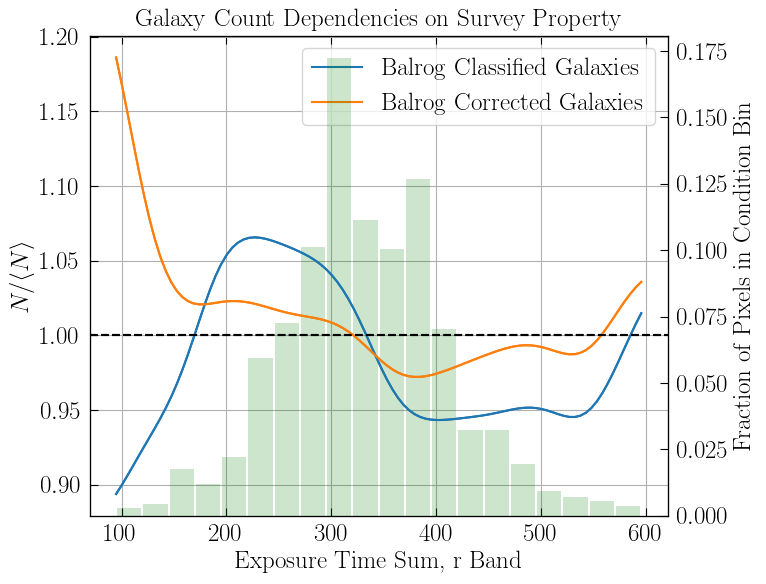

In [19]:
import matplotlib.style
import matplotlib

matplotlib.style.use('des_dr1')

for condInd in [37]:#range(len(Config.conditions)):

    condition = Config.conditions[condInd]
    condValues = fitsio.read(strConfig.condFiles[condInd])['SIGNAL']
    fullCond = np.zeros(12*512**2)
    fullCond[validPix] = condValues
    condValues = fullCond[galaPix]

    x = np.linspace(np.average(condValues)-3*np.std(condValues), np.average(condValues)+3*np.std(condValues), numBins)
    x = x[np.where(x <= np.max(condValues))[0]]
    x = x[np.where(x >= np.min(condValues))[0]]
    galaSigma = sigma * np.std(condValues)
    yOrig = []
    yCorr = []

    for xi in x:
        # Gaussian weighting the values close by to each x value.
        totOrigWeightedCounts = np.sum(origGalaCounts * np.exp(-1*(((condValues - xi) / galaSigma)**2)))
        totOrigWeightedPixels = np.sum(np.exp(-1*(((condValues - xi) / galaSigma)**2)))
        yOrig.append((totOrigWeightedCounts / totOrigWeightedPixels) / aveOrigCount)

        totCorrWeightedCounts = np.sum(corrGalaCounts * np.exp(-1*(((condValues - xi) / galaSigma)**2)))
        totCorrWeightedPixels = np.sum(np.exp(-1*(((condValues - xi) / galaSigma)**2)))
        yCorr.append((totCorrWeightedCounts / totCorrWeightedPixels) / aveCorrCount)

    yOrig = np.array(yOrig)
    yCorr = np.array(yCorr)
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(condition)
    ax1.tick_params(axis='y')
    ax1.set_ylabel(r'$N / \langle N\rangle$')
    ax1.plot(x, yOrig, label = 'Balrog Classified Galaxies')
    ax1.plot(x, yCorr, label = 'Balrog Corrected Galaxies')
    ax1.axhline(y = 1, color = 'black', linestyle = '--')
    ax1.grid()
    ax1.legend()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.tick_params(axis='y')
    ax2.set_ylabel('Fraction of Pixels in Condition Bin')
    ax2.hist(condValues, bins = np.linspace(np.min(x), np.max(x), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condValues)) / len(condValues))

    ax3 = ax1.twinx()
    ax3.tick_params(axis='y', right = False, labelright = False)
    ax3.plot(x, yOrig)
    ax3.plot(x, yCorr)
    ax3.axhline(y = 1, color = 'black', linestyle = '--')


    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Galaxy Count Dependencies on Survey Property')
    plt.show()